# EE226 - Coding 3
## PageRank & node2vec

### PageRank

### Setup

You should be able to see the dataset we will use for this Kaggle notebook under the "Data" tab on the right panel.

Next, we import some of the common libraries needed for our task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data Loading

For this task we will be using [NetworkX](https://networkx.github.io), a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. This package is applied to preprocess the original data. 

The dataset we will analyze is a snapshot of the Web Graph from the Google programming contest, 2002.

In [2]:
import networkx as nx

G_tmp = nx.read_edgelist('../input/google-web-graph/web-Google.txt', create_using = nx.DiGraph)
print(nx.info(G_tmp))

Name: 
Type: DiGraph
Number of nodes: 875713
Number of edges: 5105039
Average in degree:   5.8296
Average out degree:   5.8296


To begin with, let's simplify our analysis by ignoring the dangling nodes and the disconnected components in the original graph.

Use NetworkX to identify the **largest** weakly connected component in the ```G_tmp``` graph.  From now on, use the connected component ```G``` for all the following tasks.

In [3]:
# # The simplest method, but not available in Kaggle environment.
# G = max(nx.weakly_connected_components(G_tmp), key=len) 

# The alternate method
c = sorted(nx.weakly_connected_components(G_tmp), key=len, reverse=True)
wcc_set = c[0]
G = G_tmp.subgraph(wcc_set)
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 855802
Number of edges: 5066842
Average in degree:   5.9206
Average out degree:   5.9206


### Your Task

Compute the PageRank vector, using the existing NetworkX graph object ```G```.

The teleport probability is 0.15 (that is, each step is about to jump to some random node with probability 0.15).

You can validate your result via the ```pagerank``` function with default parameters in NetworkX: [https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html#networkx.algorithms.link_analysis.pagerank_alg.pageranky](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html#networkx.algorithms.link_analysis.pagerank_alg.pagerank)
But **do not** use it in your own work.

In [4]:
#nx.pagerank(G)
#init
rank={}
rank_pre={}
page_info={}
out_degree={}

node_num=len(G.nodes())
init_value=1.0/node_num

for node in G.nodes():
    rank[node]=init_value
    rank_pre[node]=init_value
    page_info[node]=[]
    out_degree[node]=G.out_degree(node)

# a dict,key for nodes,value for a list of in-edges
for k,v in G.edges():
    page_info[v].append(k)

In [5]:
# calculate error
def error(rank,rank_pre):
    err = sum([abs(rank[n] - rank_pre[n]) for n in rank])
    return err

# pagerank
def ranksum(node,page_info,rank_pre):
    sum=0
    for x in page_info[node]:
        sum+=rank_pre[x]/out_degree[x]
    return sum

#iter
err=1
while(err>node_num*1e-6):
    rank_pre=rank.copy()
    for node in G.nodes():
        rank[node]=(1-0.85)/node_num + 0.85 * ranksum(node,page_info,rank_pre)
    err=error(rank,rank_pre)

In [6]:
rank_comp=nx.pagerank(G,tol=1e-6)

In [7]:
rank1 = sorted(rank.items(), key=lambda x: x[1], reverse=True)
rank2 = sorted(rank_comp.items(), key=lambda x: x[1], reverse=True)
print(rank1[:5])
print(rank2[:5])
# Basically the result is similar. The reason for differences is that 
# nx.pagerank considers dangling while mine does not.

[('163075', 0.0008010119732854166), ('837478', 0.0007902223392015811), ('597621', 0.0007743519727616661), ('537039', 0.0007627350670247663), ('885605', 0.0007198393665046458)]
[('163075', 0.0009696116711473416), ('597621', 0.0009183654689187565), ('537039', 0.0009120917241781728), ('837478', 0.0008936946957973367), ('885605', 0.0008374772777914541)]


### Node2Vec

[Node2Vec](https://dl.acm.org/doi/abs/10.1145/2939672.2939754) is a random-walk based network embedding method, It proposes a biased random walk procedure, which efficiently explores diverse neighborhoods. The generated embeddings can be used for downstream tasks such as node classification, clustering, and community detection.

### Setup

First of all, we install the [nodevectors library](https://github.com/VHRanger/nodevectors) which offers a fast implementation of the node2vec method.

If you are curious to learn how to implement fast random walks on graphs, you are recommanded to read [the blog post](https://www.singlelunch.com/2019/08/01/700x-faster-node2vec-models-fastest-random-walks-on-a-graph/) which explains some of the design choices behind this library.

In [8]:
# Due to the significant internal refactoring of gensim 4.0.0, we need to degrade it for consistency
!pip install gensim==3.6.0
!pip install nodevectors


     |████████████████████████████████| 23.1 MB 22.8 MB/s 
  Created wheel for gensim: filename=gensim-3.6.0-cp37-cp37m-linux_x86_64.whl size=24239062 sha256=f4e49f9e3311ca12f277e99efa9728f1bad5212aafb8c116203e313e17582957
  Stored in directory: /root/.cache/pip/wheels/53/c8/f9/afb722099bdb5d73e5807019ce1512fd065502ccc15ea2b5bd
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
  Created wheel for nodevectors: filename=nodevectors-0.1.23-py3-none-any.whl size=17959 sha256=de35bd91772d9b597aff6c11970e49a88d0b3871f815ab71b1e15be06e44abee
  Stored in directory: /root/.cache/pip/wheels/6e/6a/11/ac8620f101db

We now import the library, and create a small wrapper class which will expose only the few hyperparameters we may need to tune in this task.

In [9]:
# Common libraries may be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

# Libaries for graph processing
import nodevectors
import networkx as nx

class Node2Vec(nodevectors.Node2Vec):
    """
    Parameters
    ----------
    p : float
        p parameter of node2vec
    q : float
        q parameter of node2vec
    d : int
        dimensionality of the embedding vectors
    w : int
        length of each truncated random walk
    """
    def __init__(self, p = 1, q = 1,d = 32, w = 10):
        super().__init__(
                    n_components = d,
                    walklen = w,
                    epochs = 50,
                    return_weight = 1.0 / p,
                    neighbor_weight = 1.0 / q,
                    threads = 0,
                    w2vparams = {'window': 4,
                                'negative': 5, 
                                'iter': 10,
                                'ns_exponent': 0.5,
                                'batch_words': 128})

### Example

Now we will study the behavior of node2vec on [barbell graphs](https://en.wikipedia.org/wiki/Barbell_graph).

Below you can see a toy example of a barbell graph generated with NetworkX.

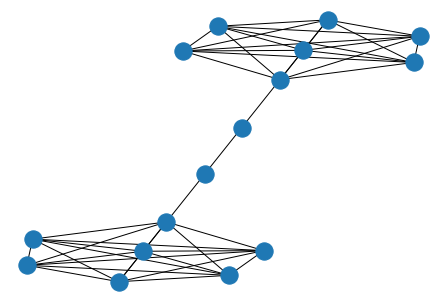

In [10]:
# A toy example, not for your task
toy_barbell = nx.barbell_graph(7, 2)
nx.draw_kamada_kawai(toy_barbell)

We can embed the nodes into 2-dimensional vectors using ```node2vec```, the example code is as follows:

In [11]:
# Use Node2Vec class to embed nodes
n2v = Node2Vec(p = 1, q = 1, d = 2)
n2v.fit(toy_barbell)
embeddings = []
for node in toy_barbell.nodes:
    embeddings.append(list(n2v.predict(node)))   

Making walks... Done, T=2.98
Mapping Walk Names... Done, T=0.04
Training W2V... Done, T=0.22


<AxesSubplot:xlabel='x', ylabel='y'>

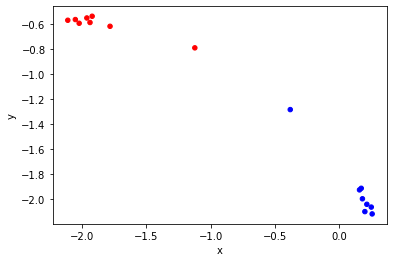

In [12]:
# Construct a pandas dataframe with the 2D embeddings from node2vec.
# We can easily divide the nodes into two clusters, and the groudtruth is denoted by distinct colors.
toy_colors = ['red'] * 8 + ['blue'] * 8
df = pd.DataFrame(embeddings, columns = ['x', 'y']) # Create pandas dataframe from the list of node embeddings
df.plot.scatter(x = 'x', y = 'y', c = toy_colors)

Then we can visualize the 2-dimensional embeddings through a scatter plot. If our example is trained correctly, you should notice two distinct clusters (one with red color, the other with blue). This is a naive example showing the graph structure feature extraction capability of node2vec.

You can tune the hyperparameters ```p```, ```q``` and ```w```, and notice how they affect the resulting embeddings.

### Your Task

Here is a larger barbell graph, where each complete graph has exactly 1000 nodes, and the path length between the complete graphs is equal to 1 (i.e., all the nodes in the barbell graph belong to either one of the two complete graphs, and the connecting path does not have any internal node).

Then, you need to learn node2vec embeddings on this graph, setting ```p = 1, q = 1, d = 10``` and ```w = 10```.

In [13]:
# A barbell graph for your task 2.1
barbell_1 = nx.barbell_graph(1000, 0)

In [14]:
# Node2Vec
n2v1 = Node2Vec(p = 1, q = 1, d = 10)
n2v1.fit(barbell_1)
embeddings1 = []
for node in barbell_1.nodes:
    embeddings1.append(list(n2v1.predict(node)))   

Making walks... Done, T=0.59
Mapping Walk Names... Done, T=1.71
Training W2V... Done, T=37.49


Write a function that takes as input a node id ```n``` in the graph (e.g., ```5```) and returns a list containining the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between the node2vec vector of the input node ```n``` and all the nodes in the given barbell graph (including the similarity with ```n``` itself). You can choose a specific node and output your results.

In [15]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
mat=np.mat(embeddings1)
def cosine_sim(n):
    sim=cosine_similarity(mat)
    return sim[n]

In [16]:
# Node 5 has a higher similarity with the front nodes, and lower with latter ones.
sim=cosine_sim(5)
print(sim[0:5])
print(sim[-5:])

[0.9611651  0.95622236 0.9783985  0.95879185 0.9679452 ]
[0.14001755 0.10308899 0.10863584 0.13421488 0.12637605]


Then we generate another barbell graph, this time adding a path of length ```51``` between the two complete graphs. To find out how, refer to the NetworkX documentation: https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph

You need to learn the node2vec embeddings for the nodes of this new graph, and tune the hyperparameters to get two distinct clusters in the scatter plot. Since the scatter plot only visualize 2-dimensional vectors, if you set ```d >= 3```, you may need some additional dimensionality reduction methods (e.g., [PCA](https://blog.paperspace.com/dimension-reduction-with-principal-component-analysis/), [MDS](https://blog.paperspace.com/dimension-reduction-with-multi-dimension-scaling/) and [t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf?fbclid=IwAR0Bgg1eA5TFmqOZeCQXsIoL6PKrVXUFaskUKtg6yBhVXAFFvZA6yQiYx-M)) to generate visual results. See [t-SNE in sklearn library](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for applying t-SNE.

In [17]:
# A barbell graph for your task 2.2
barbell_2 = nx.barbell_graph(1000, 50)

In [18]:
# Learning the embeddings
n2v2 = Node2Vec(p = 1, q = 1, d = 10)
n2v2.fit(barbell_2)
embeddings2 = []
for node in barbell_2.nodes:
    embeddings2.append(list(n2v2.predict(node)))   

Making walks... Done, T=0.56
Mapping Walk Names... Done, T=4.14
Training W2V... Done, T=38.34


In [19]:
# T-SNE for dimensionally reduction
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(embeddings2)

<AxesSubplot:xlabel='x', ylabel='y'>

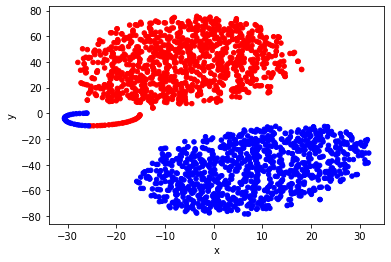

In [20]:
# Visualize
toy_colors = ['red'] * 1025 + ['blue'] * 1025
df = pd.DataFrame(X_embedded, columns = ['x', 'y']) # Create pandas dataframe from the list of node embeddings
df.plot.scatter(x = 'x', y = 'y', c = toy_colors)